In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import imageio
import matplotlib
import sys
import pandas as pd

# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(r'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM

In [2]:
tidy3dAPI = os.environ["API_TIDY3D_KEY"]

In [3]:
a = 1
medium = td.Medium(permittivity=11.56)
run = True

In [4]:
lambdas =  a/np.array([0.25,0.52])

In [5]:
folder_path=rf"H:\phd stuff\tidy3d\Notebooks\20250408 gyromorphs\Structures"
project_name = fr"20250409 Transmission gyromorphs - SHU 25 x 25"
empty=False
runtime_ps = 25e-12
min_steps_per_lambda = 20
id0 = ""
add_ref = True
size_y = 25
size_x = 25


In [6]:
data = []
for l,file in enumerate((os.listdir(folder_path))):
    print(Path(file).stem)
    data_csv = pd.read_csv(os.path.join(folder_path, file))
    if "gyro" in file:
        data_csv*=25
    else: 
        data*=1
    data.append(data_csv)
    print(data[l].head())
    

gyro24
           x         y
0   5.154421 -5.010070
1  -7.099223  2.442266
2   6.558950 -2.736269
3  11.699288  6.042212
4   0.117904 -1.896312
gyro60
          x         y
0  4.586080 -5.004112
1 -5.296106  1.416446
2  5.077981 -1.789904
3 -1.332475 -3.934826
4 -3.071756  4.111005
shu_chi_0.4
           x          y
0  -2.604591   2.051943
1   0.766759  19.758535
2  37.830216  10.983416
3   8.170693 -49.044895
4  46.381352 -49.985290


gyro24 Transmission 0.25 - 0.52
Configured successfully.


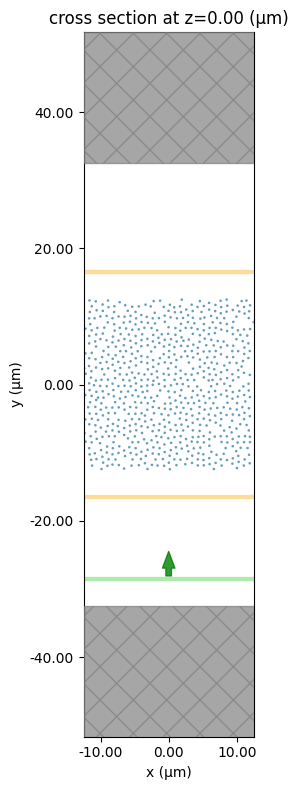

13:36:19 W. Europe Daylight Time Created task 'gyro24 Transmission 0.25 -       
                                 0.52_0' with task_id                           
                                 'fdve-2e4f27f9-66b3-4a2b-8f70-f0198cb1370a' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=47951;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2e4f27f9-66b3-4a2b-8f70-f0198cb1370a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=448769;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2e4f27f9-66b3-4a2b-8f70-f0198cb1370a\task]8;;\
                                 ]8;id=448769;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2e4f27f9-66b3-4a2b-8f70-f0198cb1370a\Id]8;;\]8;id=47951;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2e4f27f9-66b3-4a2b-8f70-f0198cb1370a\=]8;;\]8;id=61388;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2e4f27f9-66b3-4a2b-8f70-f0198cb1370a\fdve]8;;\]8;id=47951;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2e4f27f9-66b3-4a2b-8f70-f0198cb1370a\-2e4f27f9-66b3-4a2b-8f70-f0198cb1370a']8;;\.

                                 Task folder: ]8;id=45934;https://tidy3d.simulation.cloud/folders/folder-56f73be1-6975-46f2-9a84-82056c6942ca\'20250409 Transmission gyromorphs ]8;;\
                                 ]8;id=45934;https://tidy3d.simulation.cloud/folders/folder-56f73be1-6975-46f2-9a84-82056c6942ca\- SHU 25 x 25']8;;\.

Output()

13:36:21 W. Europe Daylight Time Maximum FlexCredit cost: 0.025. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

13:36:22 W. Europe Daylight Time status = queued

                                 To cancel the simulation, use                  
                                 'web.abort(task_id)' or 'web.delete(task_id)'  
                                 or abort/delete the task in the web UI.        
                                 Terminating the Python script will not stop the
                                 job running on the cloud.

Output()

13:36:31 W. Europe Daylight Time starting up solver

                                 running solver

Output()

13:36:56 W. Europe Daylight Time status = success

                                 View simulation result at                      
                                 ]8;id=644332;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2e4f27f9-66b3-4a2b-8f70-f0198cb1370a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=600789;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2e4f27f9-66b3-4a2b-8f70-f0198cb1370a\task]8;;\
                                 ]8;id=600789;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2e4f27f9-66b3-4a2b-8f70-f0198cb1370a\Id]8;;\]8;id=644332;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2e4f27f9-66b3-4a2b-8f70-f0198cb1370a\=]8;;\]8;id=4373;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2e4f27f9-66b3-4a2b-8f70-f0198cb1370a\fdve]8;;\]8;id=644332;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2e4f27f9-66b3-4a2b-8f70-f0198cb1370a\-2e4f27f9-66b3-4a2b-8f70-f0198cb1370a']8;;\.

                                 Created task 'gyro24 Transmission 0.25 - 0.52' 
                                 with task_id                                   
                                 'fdve-f1ffe0df-7d7f-45f5-9b56-828ebdde9365' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=162415;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f1ffe0df-7d7f-45f5-9b56-828ebdde9365\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=592526;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f1ffe0df-7d7f-45f5-9b56-828ebdde9365\task]8;;\
                                 ]8;id=592526;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f1ffe0df-7d7f-45f5-9b56-828ebdde9365\Id]8;;\]8;id=162415;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f1ffe0df-7d7f-45f5-9b56-828ebdde9365\=]8;;\]8;id=994635;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f1ffe0df-7d7f-45f5-9b56-828ebdde9365\fdve]8;;\]8;id=162415;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f1ffe0df-7d7f-45f5-9b56-828ebdde9365\-f1ffe0df-7d7f-45f5-9b56-828ebdde9365']8;;\.

                                 Task folder: ]8;id=261748;https://tidy3d.simulation.cloud/folders/folder-56f73be1-6975-46f2-9a84-82056c6942ca\'20250409 Transmission gyromorphs ]8;;\
                                 ]8;id=261748;https://tidy3d.simulation.cloud/folders/folder-56f73be1-6975-46f2-9a84-82056c6942ca\- SHU 25 x 25']8;;\.

Output()

13:36:59 W. Europe Daylight Time Maximum FlexCredit cost: 0.025. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

13:37:00 W. Europe Daylight Time status = queued

                                 To cancel the simulation, use                  
                                 'web.abort(task_id)' or 'web.delete(task_id)'  
                                 or abort/delete the task in the web UI.        
                                 Terminating the Python script will not stop the
                                 job running on the cloud.

Output()

13:37:07 W. Europe Daylight Time starting up solver

                                 running solver

Output()

13:37:29 W. Europe Daylight Time status = postprocess

Output()

13:37:32 W. Europe Daylight Time status = success

13:37:34 W. Europe Daylight Time View simulation result at                      
                                 ]8;id=684247;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f1ffe0df-7d7f-45f5-9b56-828ebdde9365\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=624211;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f1ffe0df-7d7f-45f5-9b56-828ebdde9365\task]8;;\
                                 ]8;id=624211;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f1ffe0df-7d7f-45f5-9b56-828ebdde9365\Id]8;;\]8;id=684247;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f1ffe0df-7d7f-45f5-9b56-828ebdde9365\=]8;;\]8;id=451976;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f1ffe0df-7d7f-45f5-9b56-828ebdde9365\fdve]8;;\]8;id=684247;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f1ffe0df-7d7f-45f5-9b56-828ebdde9365\-f1ffe0df-7d7f-45f5-9b56-828ebdde9365']8;;\.

Folder 'H:\phd stuff\tidy3d\data/20250409 Transmission gyromorphs - SHU 25 x 25/gyro24' created successfully.
gyro60 Transmission 0.25 - 0.52
Configured successfully.


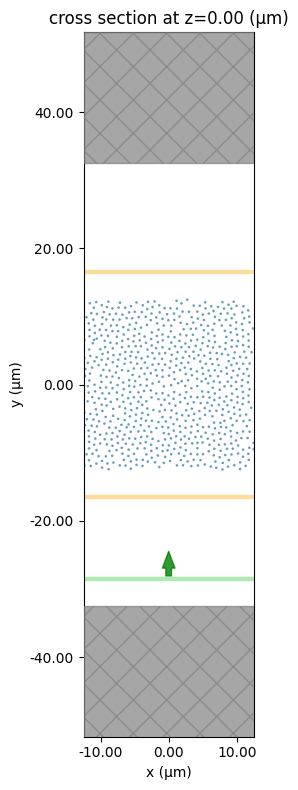

13:37:35 W. Europe Daylight Time Created task 'gyro60 Transmission 0.25 - 0.52' 
                                 with task_id                                   
                                 'fdve-ed597798-4a52-438a-8268-f464dab30e46' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=944897;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ed597798-4a52-438a-8268-f464dab30e46\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=784293;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ed597798-4a52-438a-8268-f464dab30e46\task]8;;\
                                 ]8;id=784293;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ed597798-4a52-438a-8268-f464dab30e46\Id]8;;\]8;id=944897;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ed597798-4a52-438a-8268-f464dab30e46\=]8;;\]8;id=523866;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ed597798-4a52-438a-8268-f464dab30e46\fdve]8;;\]8;id=944897;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ed597798-4a52-438a-8268-f464dab30e46\-ed597798-4a52-438a-8268-f464dab30e46']8;;\.

                                 Task folder: ]8;id=178434;https://tidy3d.simulation.cloud/folders/folder-56f73be1-6975-46f2-9a84-82056c6942ca\'20250409 Transmission gyromorphs ]8;;\
                                 ]8;id=178434;https://tidy3d.simulation.cloud/folders/folder-56f73be1-6975-46f2-9a84-82056c6942ca\- SHU 25 x 25']8;;\.

Output()

13:37:38 W. Europe Daylight Time Maximum FlexCredit cost: 0.025. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

13:37:39 W. Europe Daylight Time status = queued

                                 To cancel the simulation, use                  
                                 'web.abort(task_id)' or 'web.delete(task_id)'  
                                 or abort/delete the task in the web UI.        
                                 Terminating the Python script will not stop the
                                 job running on the cloud.

Output()

13:37:46 W. Europe Daylight Time starting up solver

                                 running solver

Output()

13:38:07 W. Europe Daylight Time status = success

                                 View simulation result at                      
                                 ]8;id=809602;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ed597798-4a52-438a-8268-f464dab30e46\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=634900;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ed597798-4a52-438a-8268-f464dab30e46\task]8;;\
                                 ]8;id=634900;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ed597798-4a52-438a-8268-f464dab30e46\Id]8;;\]8;id=809602;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ed597798-4a52-438a-8268-f464dab30e46\=]8;;\]8;id=62057;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ed597798-4a52-438a-8268-f464dab30e46\fdve]8;;\]8;id=809602;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ed597798-4a52-438a-8268-f464dab30e46\-ed597798-4a52-438a-8268-f464dab30e46']8;;\.

Folder 'H:\phd stuff\tidy3d\data/20250409 Transmission gyromorphs - SHU 25 x 25/gyro60' created successfully.
shu_chi_0.4 Transmission 0.25 - 0.52
Configured successfully.


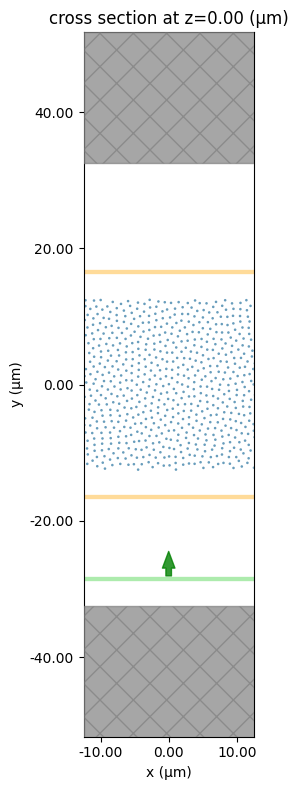

13:38:09 W. Europe Daylight Time Created task 'shu_chi_0.4 Transmission 0.25 -  
                                 0.52' with task_id                             
                                 'fdve-f4b623bc-9fc4-4b15-88b3-d08a80dc7d06' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=885022;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4b623bc-9fc4-4b15-88b3-d08a80dc7d06\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=536895;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4b623bc-9fc4-4b15-88b3-d08a80dc7d06\task]8;;\
                                 ]8;id=536895;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4b623bc-9fc4-4b15-88b3-d08a80dc7d06\Id]8;;\]8;id=885022;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4b623bc-9fc4-4b15-88b3-d08a80dc7d06\=]8;;\]8;id=952467;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4b623bc-9fc4-4b15-88b3-d08a80dc7d06\fdve]8;;\]8;id=885022;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4b623bc-9fc4-4b15-88b3-d08a80dc7d06\-f4b623bc-9fc4-4b15-88b3-d08a80dc7d06']8;;\.

                                 Task folder: ]8;id=842953;https://tidy3d.simulation.cloud/folders/folder-56f73be1-6975-46f2-9a84-82056c6942ca\'20250409 Transmission gyromorphs ]8;;\
                                 ]8;id=842953;https://tidy3d.simulation.cloud/folders/folder-56f73be1-6975-46f2-9a84-82056c6942ca\- SHU 25 x 25']8;;\.

Output()

13:38:12 W. Europe Daylight Time Maximum FlexCredit cost: 0.025. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

13:38:13 W. Europe Daylight Time status = queued

                                 To cancel the simulation, use                  
                                 'web.abort(task_id)' or 'web.delete(task_id)'  
                                 or abort/delete the task in the web UI.        
                                 Terminating the Python script will not stop the
                                 job running on the cloud.

Output()

13:38:29 W. Europe Daylight Time starting up solver

                                 running solver

Output()

13:38:44 W. Europe Daylight Time status = postprocess

Output()

13:38:46 W. Europe Daylight Time status = success

13:38:48 W. Europe Daylight Time View simulation result at                      
                                 ]8;id=501081;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4b623bc-9fc4-4b15-88b3-d08a80dc7d06\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=980800;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4b623bc-9fc4-4b15-88b3-d08a80dc7d06\task]8;;\
                                 ]8;id=980800;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4b623bc-9fc4-4b15-88b3-d08a80dc7d06\Id]8;;\]8;id=501081;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4b623bc-9fc4-4b15-88b3-d08a80dc7d06\=]8;;\]8;id=136078;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4b623bc-9fc4-4b15-88b3-d08a80dc7d06\fdve]8;;\]8;id=501081;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4b623bc-9fc4-4b15-88b3-d08a80dc7d06\-f4b623bc-9fc4-4b15-88b3-d08a80dc7d06']8;;\.

Folder 'H:\phd stuff\tidy3d\data/20250409 Transmission gyromorphs - SHU 25 x 25/shu_chi_0.4' created successfully.


In [7]:

for k,item in enumerate(data):
        #Tight pulse 

        run_name = f"{Path(os.listdir(folder_path)[k]).stem} Transmission {1/lambdas[0]:.3g} - {1/lambdas[1]:.3g}"
        print(run_name)
        structure_1 = AM.loadAndRunStructure(key = tidy3dAPI
                    ,direction="z", lambda_range=lambdas,
                    box_size= 50,runtime_ps=runtime_ps,min_steps_per_lambda=min_steps_per_lambda,
                   scaling=1,shuoff_condtion=1e-20, verbose=True,
                   monitors=["flux"],
                   freqs=400, 
                   source="planewave", 
                   width=0.35, ref_only=True
                   )


        sim = structure_1.sim



        boundaries= td.BoundarySpec(
                x=td.Boundary.periodic(),
                y=td.Boundary(plus=td.Absorber(num_layers=200),minus=td.Absorber(num_layers=200)),
                z=td.Boundary.periodic(),
            )
        sim = sim.copy(update={'boundary_spec':boundaries})
        sim = sim.copy(update={'sources':[]})
        sim = sim.copy(update={'monitors':[]})


        Lx, Ly = size_x,size_y+40,
        sim = sim.copy(update={'size':[Lx,Ly,0]})

        source = td.PlaneWave(
                source_time = td.GaussianPulse(
                    freq0=structure_1.freq0,
                    fwidth=structure_1.freqw
                ),
                size= (td.inf,0,td.inf),
                center=(0,-(Ly)/2 + lambdas[0],0),
                direction='+',
                pol_angle=np.pi/2,
                name='planewave',
                )

        sim = sim.copy(update={'sources':[source]})

      
        monitor_1 = td.FluxMonitor(
                center = (
                                0,-((size_y)/2+ lambdas[0]),0
                                ),
                size = (
                   td.inf,0,td.inf
                    ),
                freqs = structure_1.monitor_freqs,
                name='flux2' )

        monitor_2 = td.FluxMonitor(
                center = (
                                0,(size_y)/2+ lambdas[0],0
                                ),
                size = (
                   td.inf,0,td.inf
                    ),
                freqs = structure_1.monitor_freqs,
                name='flux1' 
            )

        sim = sim.copy(update={'monitors':[monitor_1,monitor_2]})

        cyl_group = []
        for x, y in zip(data[k]['x'], data[k]['y']):
            x,y = x,y
            if np.abs(y)<=(size_y/2):
                cyl_group.append(td.Cylinder(center=[x, y, 0], radius=0.189, length=td.inf))

        cylinders = td.Structure(geometry=td.GeometryGroup(geometries=cyl_group), medium=medium)


        if empty:
            sim = sim.copy(update={'structures':[],"grid_spec": td.GridSpec.uniform(dl=structure_1.dl)})
        else:
            sim = sim.copy(update={'structures':[cylinders],"grid_spec": td.GridSpec.uniform(dl=structure_1.dl)})

        sim_name = run_name
        fig, ax = plt.subplots(1, tight_layout=True, figsize=(16, 8))
        sim.plot(z=0, ax=ax)
        plt.show()

        if run:
            if add_ref:
                 id0 =web.upload(sim.copy(update={'structures':[]}), folder_name=project_name,task_name=fr"{sim_name}_0", verbose=True)
                 web.start(task_id = id0)
                 web.monitor(task_id=id0,verbose=True)
                 add_ref = False

            id =web.upload(sim, folder_name=project_name,task_name=sim_name, verbose=True)
            web.start(task_id = id)
            web.monitor(task_id=id,verbose=True)
            ids = id0+ '\n' + id
            structure_folder =Path(os.listdir(folder_path)[k]).stem
            file_path = rf"H:\phd stuff\tidy3d\data/{project_name}/{structure_folder}/{sim_name}.txt"
            # Check if the folder exists
            if not os.path.exists( fr"H:\phd stuff\tidy3d\data/{project_name}/{structure_folder}"):
                os.makedirs(fr"H:\phd stuff\tidy3d\data/{project_name}/{structure_folder}")
                print(fr"Folder 'H:\phd stuff\tidy3d\data/{project_name}/{structure_folder}' created successfully.")

            # Open file in write mode
            with open(file_path, "w") as f:
                # Write the string to the file
                f.write(ids)
        # else:
        #     sim.plot_3d()
        #     id =web.upload(sim,task_name=sim_name, verbose=True)
        #     print(web.estimate_cost(id))
        #     raise TypeError("Program ends here")

